# Business Case
There has been a growing market for electrical vehicles. Other than Tesla, there are also other emerging electrical car companies such as Nio. As an investor, I am interested in the public perception towards Nio and its' foothold in the EVs industry so that I can determine my investment decision.

To tackle the problem, I will use Sentiment Analysis through the subreddit posts of Nio.

In [263]:
#Import packages
from api_funcs import *
import re 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.collocations import *
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import random
#from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer
from textblob import Blobber
from sklearn.feature_extraction.text import CountVectorizer #, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB #, GaussianNB

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('movie_reviews')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sky\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Sky\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Sky\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

## Data scraping using Reddit API

In [20]:
#Scrap subreddit posts from Nio subreddit
posts = subreddit_posts('Nio', 1000)

In [21]:
posts.shape

(785, 6)

In [22]:
#exporting posts to a csv file
posts.to_csv('Nio_posts.csv', index=False)

In [23]:
#Get the replies to the subreddit posts
replies = replies_to_posts(posts)

In [24]:
replies.shape

(7582, 4)

In [25]:
#exporting posts to a csv file
replies.to_csv('Nio_replies.csv', index=False)

## Data Cleaning and Preprocessing

In [26]:
posts = pd.read_csv('Nio_posts.csv')
replies = pd.read_csv('Nio_replies.csv')

In [27]:
posts.head(3)

,Title,URL,Body,Upvotes,Time,Key
0,NIO Daily Investor Discussion,https://www.reddit.com/r/Nio/comments/iuztg9/n...,This thread is to comment on the daily NIO st...,15,2020-09-18 17:00:10,0
1,I think Nio looks better! 😆 What you all think?,https://www.reddit.com/r/Nio/comments/iv7fxj/i...,NaN,64,2020-09-19 02:47:30,1
2,Tesla battery day affecting Nio,https://www.reddit.com/r/Nio/comments/iv9beg/t...,Do you think we can expect a dip in Nio stock ...,2,2020-09-19 04:26:32,2


In [28]:
replies.head(3)

,Reply,Upvote,Time,Key
0,NIO outperformed the market today. Tesla and t...,9.0,2020-09-18 17:37:35,0.0
1,Flirting with $20 in pre market :D,7.0,2020-09-18 22:40:31,0.0
2,And flop,3.0,2020-09-19 01:47:28,0.0


Get the title rows and reply rows of posts and replies, respectively.
Then concatenate them into a dataframe called 'data'.

In [137]:
title_texts = posts['Title']
reply_texts = replies['Reply']
data = pd.concat([title_texts, reply_texts])

In [138]:
#exporting all the title posts and replies to a csv file called 'data.csv'
data.to_csv('Nio_data.csv',index=False)

In [141]:
data = pd.read_csv('Nio_data.csv')

In [143]:
#rename the column to 'text'
data.columns = ['text']

In [145]:
data.head()

,text
0,NIO Daily Investor Discussion
1,I think Nio looks better! 😆 What you all think?
2,Tesla battery day affecting Nio
3,EC6 Go (Souce: Weibo)
4,EC6 mass production line rolling out and expec...


Dropping Rows with Null Values

In [178]:
data.dropna(subset=['text'], inplace=True)

Transform to all Lowercase

In [179]:
data.text = data.text.str.lower()

Remove Punctuation

In [181]:
#use regular expression, re.sub() returns a string/row that is not '\w', '\s', as 
#the symbol '^' is the negation.
data.text = data.text.apply(lambda x: re.sub(r'[^\w\s]', '', x))

Remove Stopwords

In [182]:
stopwords = stopwords.words('english') #specify the language and get the stopwords in that language

#going through each of the text and removing any words that is in stopwords
data.text = data.text.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))

Removing links

In [183]:
data.text = data.text.apply(lambda x: re.sub(r'\(?http\S+', '', x))

Normalising Words using Lemmatization

In [184]:
lemmatizer = nltk.WordNetLemmatizer() #Lemmatization will look at the words and
                                        #try to find the base form of the words
data.text = data.text.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))

Removing the Remaining Null Rows after Cleaning

In [189]:
data.dropna(subset=['text'], inplace=True)

In [190]:
data.head(2)

,text
0,nio daily investor discussion
1,think nio look better think


## Data Exploration

###### Bigrams

In [186]:
#get all the rows.
#.str.cat(sep='.') joins them into a single string and separate them by '. '
data_string = data.iloc[:].text.str.cat(sep='. ')

In [187]:
#transform the data_string into a data list so it can interate through each word.
data_list = nltk.word_tokenize(data_string)

In [188]:
#a function that returns a bigram
#top_n is how many bigrams we want to return
def common_bigrams(tokenized_text, min_freq, top_n):
    bigrams_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    finder.apply_freq_filter(min_freq)
    finder.nbest(bigrams_measures.pmi, top_n)
    return finder.nbest(bigrams_measures.pmi, top_n)

print(common_bigrams(data_list, 30, 10)) #look at the bigrams that appear
                                        #atleast 10 times and we want to look at
                                        #the top 10 bigrams.

[('gross', 'margin'), ('gon', 'na'), ('swap', 'station'), ('investor', 'discussion'), ('battery', 'swapping'), ('daily', 'investor'), ('make', 'sense'), ('battery', 'swap'), ('market', 'cap'), ('long', 'term')]


###### From the bigram list, we can get the ideas of what are the topics surrounding Nio.

('swap', 'station'), ('battery', 'swapping'), ('battery', 'swap'), bigrams refer to one of the most attrative business endeavor for Nio. Which is the idea of having efficient battery swapping station so user can just swap battery on the go instead of waiting at a charging station.

('gross', 'margin') may refers to the high interests of how Nio is going to scale their production in a larger capicity in order to yield the most profits.

('long', 'term') may refers to the debate of whether or not Nio is a good company long term and is it a good investion long term. 

###### Wordcloud

In [191]:
#a colour function that we will need for the word cloud
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

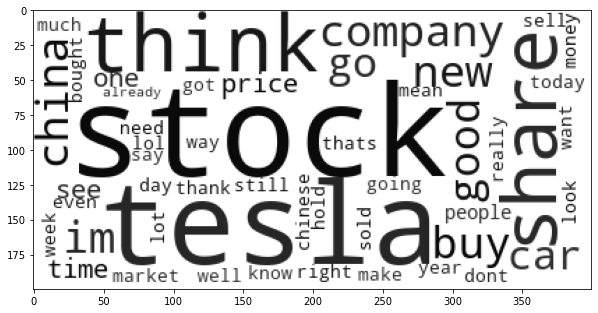

In [197]:
stp = STOPWORDS.copy() #we assign stop words to a variable
#we can also add more words to stp so wordcloud can filter it out, eg.'Nio'
stp.add('Nio')

#we put the stopwords in the parameter, so the wordcloud will ignore them
#the wordcloud also takes into account groups of words, bigrams, trigrams, etc...
#so if we dont want wordcloud to account for that, we can
#add another parameter (collocations = False).
wc = WordCloud(background_color="white", max_words=50, stopwords=stp)

# generate word cloud
wc.generate(data_string)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func =grey_color_func, random_state=3))
plt.show()

From the wordcloud, we can see that Tesla is highlighted, this makes sense because even though, Nio cannot directly compete with Tesla but it's a great reference point for Nio.

China is in the wordcloud because Nio is a based in China.

Also, it is a good sign that Buy is mentioned more than Sell.

# Sentiment Analysis

###### Prebuilt Package TextBlob

In [205]:
#initialise TextBlob
tba = Blobber(analyzer=NaiveBayesAnalyzer())

In [234]:
#creating and add new columns to the database
#we have to extract each element because the Textblob .sentiment method doesnt
#return a dictionary like Vader.
data[['Classification', 'positive', 'negative']] = data.text.apply(lambda x: pd.Series({'Classification':tba(x).sentiment[0],
                                                                                    'positive':tba(x).sentiment[1],
                                                                                    'negative':tba(x).sentiment[2]}))

In [235]:
data.head()

,text,Classification,positive,negative
0,nio daily investor discussion,neg,0.274086,0.725914
1,think nio look better think,neg,0.396375,0.603625
2,tesla battery day affecting nio,pos,0.742978,0.257022
3,ec6 go souce weibo,pos,0.500000,0.500000
4,ec6 mass production line rolling expected ec6 ...,pos,0.619600,0.380400


In [236]:
#total the negative texts
data.Classification.value_counts().neg

3349

In [237]:
#total the positive texts
data.Classification.value_counts().pos

5018

In [231]:
#total the negative columns
data.negative.sum()

3828.0626747514452

In [238]:
#total the positive columns
data.positive.sum()

4538.937325248555

In [239]:
#highest postive score
data.positive.max()

1.0

In [240]:
#highest negative score
data.negative.max()

0.999973003266439

###### My own Classifier

Cleaning and preprocessing train data

In [241]:
train_data = pd.read_csv('train.csv')

In [243]:
train_data.dropna(subset=['text'], inplace=True)

In [244]:
train_data.text = train_data.text.apply(lambda x: re.sub(r'[^\w\s]', '', x) )

In [246]:
stopwords = stopwords.words('english') #specify the language and get the stopwords in that language

#going through each of the text and removing any words that is in stopwords
train_data.text = train_data.text.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))

In [247]:
train_data.text = train_data.text.apply(lambda x: re.sub(r'\(?http\S+', '', x))

In [248]:
lemmatizer = nltk.WordNetLemmatizer() #Lemmatization will look at the words and
                                        #try to find the base form of the words
train_data.text = train_data.text.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))

Initial vectorizer and fit a feature matrix

In [250]:
vectorizer = CountVectorizer()

In [251]:
train_data.dropna(subset=['text'], inplace=True)
train_x = vectorizer.fit_transform(train_data.text)

In [252]:
nb = MultinomialNB()
nb.fit(train_x, train_data.sentiment)

MultinomialNB()

Fitting our data into the train data feature matrix

In [253]:
data_x = vectorizer.transform(data.text)

Using the fitted feature matrix to classify the text

In [254]:
predicted = nb.predict(data_x)

In [255]:
prediction_data = pd.read_csv('Nio_data.csv')

fitting the sentiment columns to the original data

In [256]:
prediction_data = prediction_data.assign(sentiment = predicted)

In [257]:
prediction_data

,0,sentiment
0,NIO Daily Investor Discussion,neutral
1,I think Nio looks better! 😆 What you all think?,neutral
2,Tesla battery day affecting Nio,negative
3,EC6 Go (Souce: Weibo),neutral
4,EC6 mass production line rolling out and expec...,negative
...,...,...
8362,I know i say a few reviews from China. Check o...,neutral
8363,"Hey, jin022, just a quick heads-up: \n**alot*...",neutral
8364,My order went through at 6.62 this morning. I'...,positive
8365,Good close! We are amongst the lucky ones!,positive


In [258]:
prediction_data.sentiment.value_counts().neutral

5799

In [260]:
prediction_data.sentiment.value_counts().positive

1386

In [261]:
prediction_data.sentiment.value_counts().negative

1182

# Comparing

Bar graph of TextBlob Sentiment Analysis for Nio

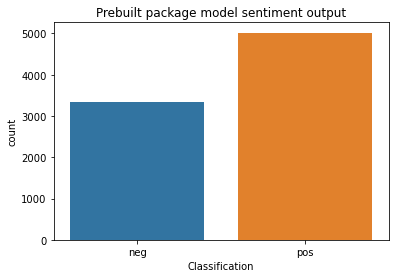

In [266]:
plt.title("Prebuilt package model sentiment output")
sns.countplot(data['Classification'])

Bar graph of my own Classifier for Nio

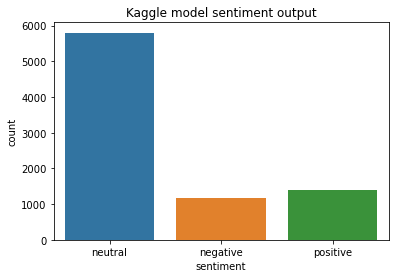

In [267]:
plt.title("Kaggle model sentiment output")
sns.countplot(prediction_data['sentiment'])

# Conclusion

* The public has a neutral perception towards Nio.
* In both models, the positive comments are slightly more than the negative comments.
* The builtin model doesn't have a neutral classification while my own classification does.
* However, the data that we scrapped from the subreddit r/Nio is relatively small. This could be because Nio is still a fairly new company.